In [1]:
%reset -f
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

# SUMMARY

**1 – DATA EXTRACTION FROM EXCEL**

- 1.1 – Running data
- 1.2 – Workout data
- 1.3 – Other activities data

**2 – GRAPHS**

- 2.1 – Daily overall graph
- 2.2 – Running graph
- 2.3 – Workout graph

# 1 – DATA EXTRACTION FROM EXCEL

In [2]:
W = np.arange(1, 53) #weeks
N = len(W) #number of weeks

save = True #if true, we save graphs in the graphs folder

### 1.1 – Running data

In [3]:
X = pd.read_excel("sport_data2023.xlsx", sheet_name="RUNNING")
X = X.values #converting the pandas dataframe to a numpy array
X = X[3:, 3:17]

Z1 = np.zeros((N, 7)) #intensity zone 1 (easy)
Z2 = np.zeros((N, 7)) #intensity zone 2 (moderated)
Z3 = np.zeros((N, 7)) #intensity zone 2 (hard)
EG = np.zeros((N, 7)) #elevation gain

for i in range(N):
    for j in range(7):
        #add distance (km)
        Z1[i, j] = np.nansum(X[5*i+1, [2*j, 2*j+1]])
        Z2[i, j] = np.nansum(X[5*i+2, [2*j, 2*j+1]])
        Z3[i, j] = np.nansum(X[5*i+3, [2*j, 2*j+1]])
        EG[i, j] = np.nansum(X[5*i+4, [2*j, 2*j+1]])

### 1.2 – Workout data

In [4]:
X = pd.read_excel("sport_data2023.xlsx", sheet_name="WORKOUT")
X = X.values #converting the pandas dataframe to a numpy array
X = X[2:, 3:10]

UPPER = np.zeros((N, 7))
ABS = np.zeros((N, 7))
LOWER = np.zeros((N, 7))

for i in range(N):
    for j in range(7):
        #add duration (min)
        UPPER[i, j] = np.nansum(X[3*i, j])
        ABS[i, j] = np.nansum(X[3*i+1, j])
        LOWER[i, j] = np.nansum(X[3*i+2, j])

WORKOUT = UPPER + ABS + LOWER

### 1.3 – Other activities data

In [5]:
X = pd.read_excel("sport_data2023.xlsx", sheet_name="OTHER")
X = X.values #converting the pandas dataframe to a numpy array
X = X[3:, 3:17]

CHARGE = np.zeros((N, 7))

for i in range(N):
    for j in range(7):
        #add charge (~ intensity * duration) of the activity 
        CHARGE[i, j] = np.nansum(X[2*i+1, [2*j, 2*j+1]])

# 2 – GRAPHS

### 2.1 – Daily overall graph

In [6]:
def color_radius_running(z1, z2, z3):
    total = z1 + z2 + z3
    color = (1.0, 0.75-min([2*z3/total+z2/total, 0.75]), 0.0, 1.0) if total>0 else "grey"
    radius = math.sqrt(total/math.pi)*0.17 if total>0 else 0.05
    return color, radius

def color_radius_workout(workout, lower):
    color = "orange" if lower>0 else "gold" if workout>0 else "grey"
    radius = math.sqrt(workout/math.pi)*0.07 if workout>0 else 0.05
    return color, radius

def color_radius_other(charge):
    color = "gold" if charge>0 else "grey"
    radius = math.sqrt(charge/math.pi)*0.25 if charge>0 else 0.05
    return color, radius

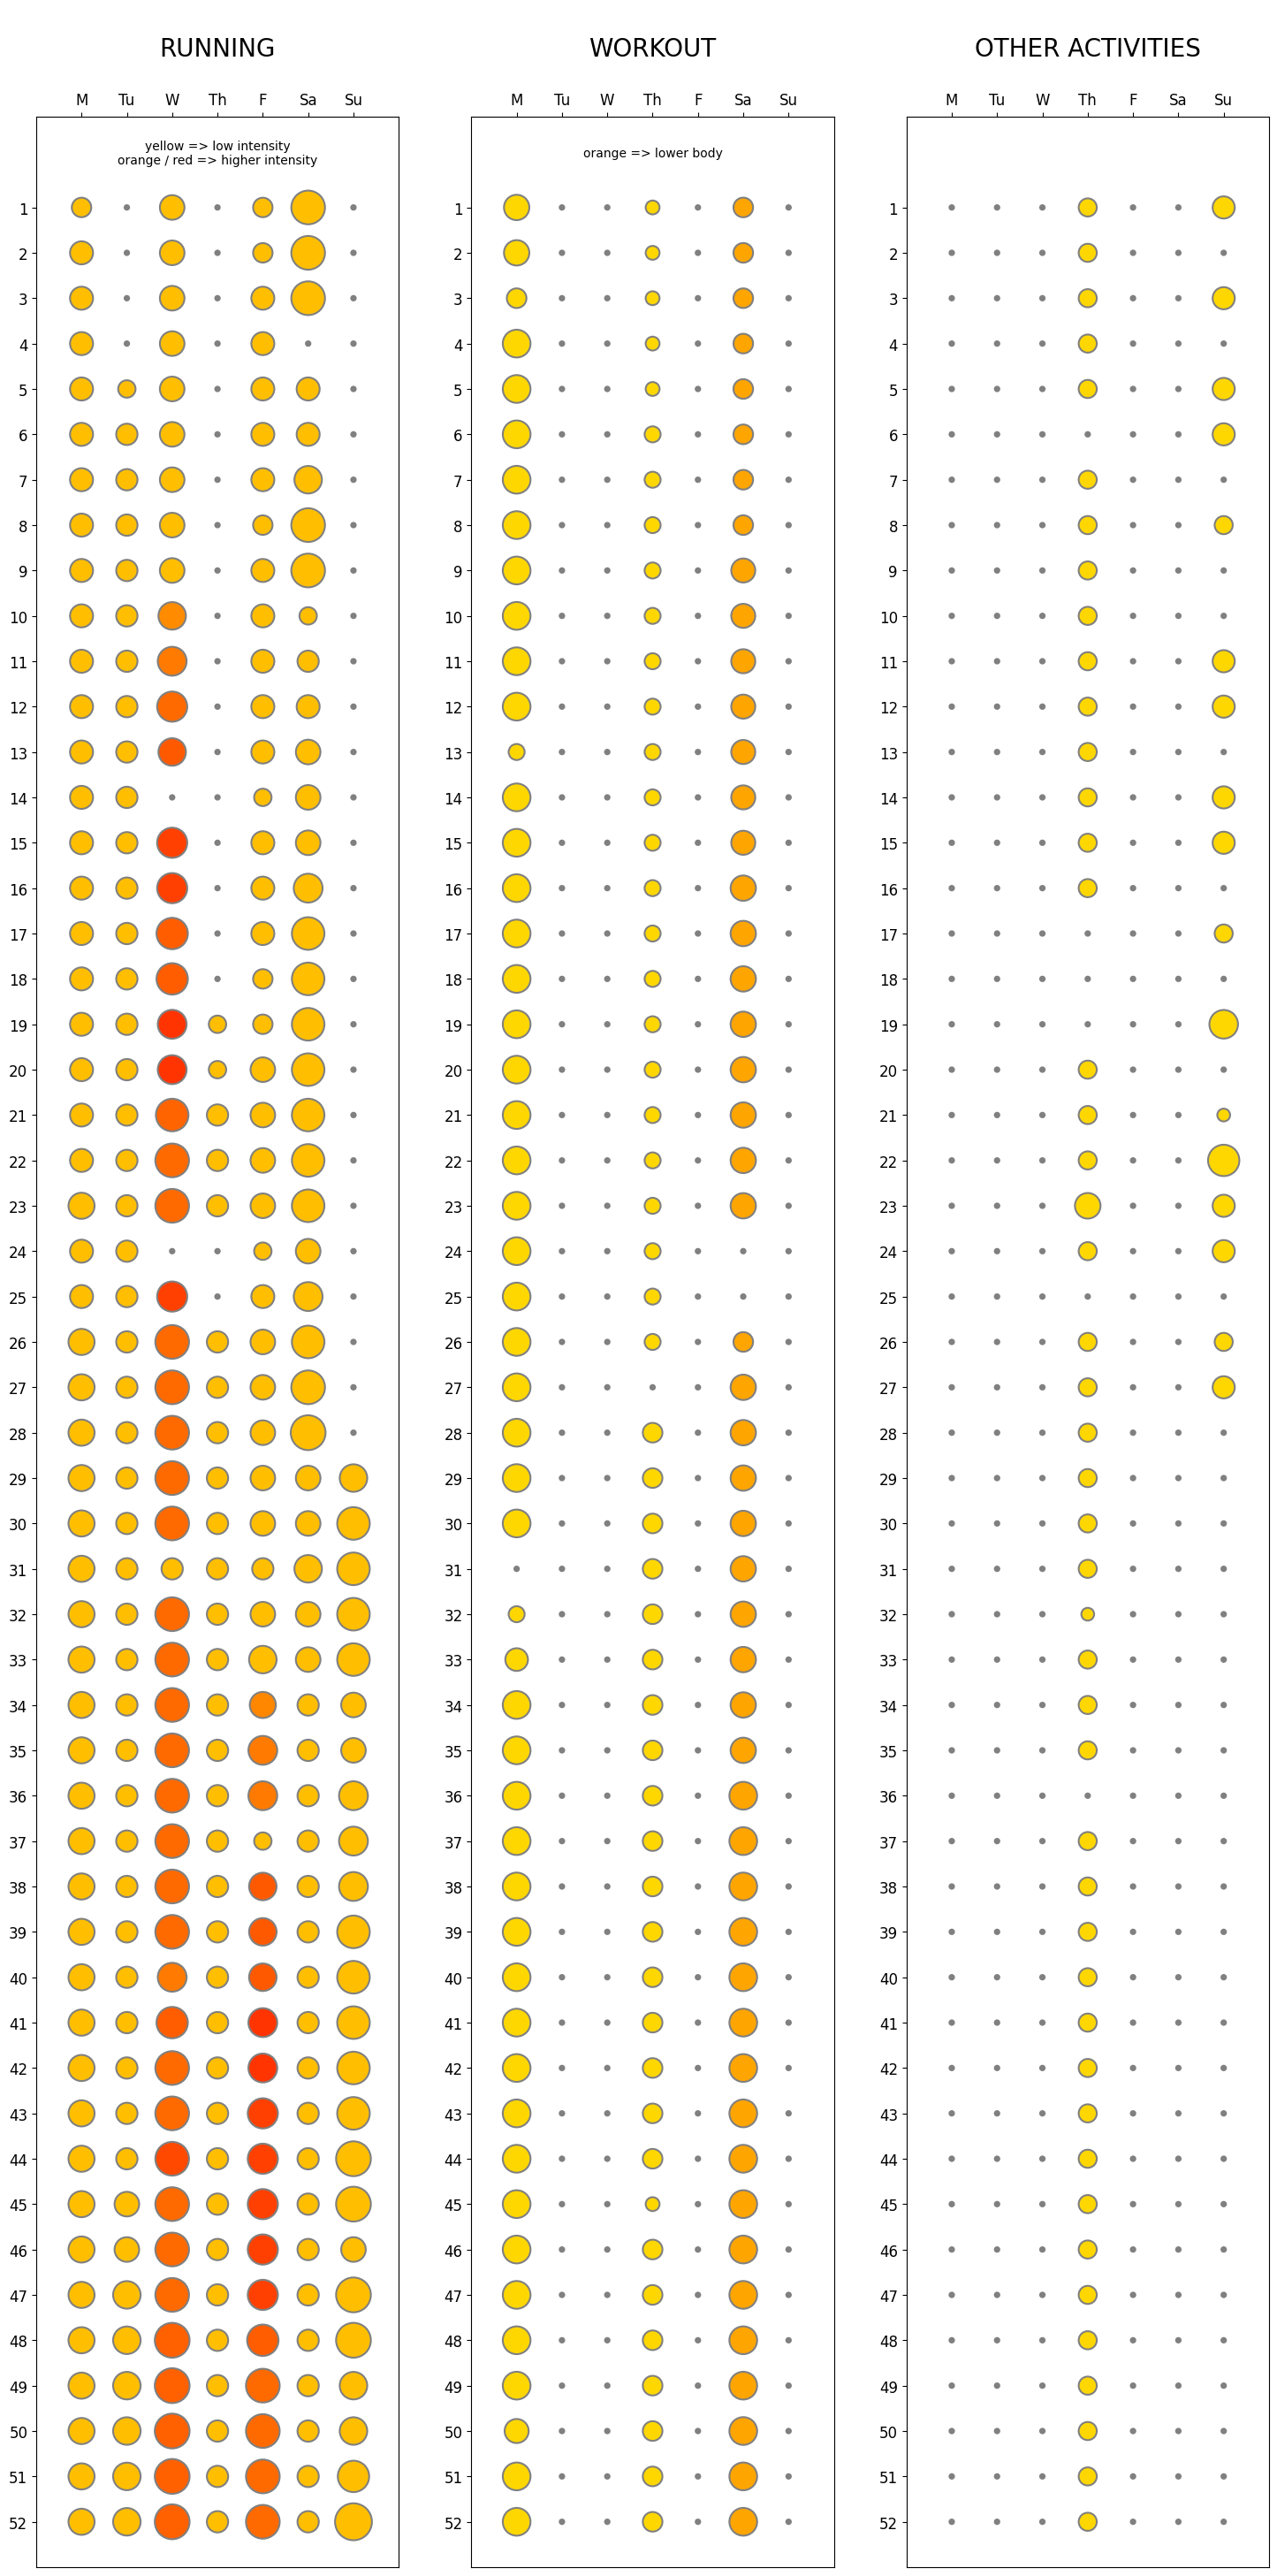

In [7]:
fig, AX = plt.subplots(1, 3, figsize=(18, 36))

#set parameters of the graph
for ax in AX:
    ax.set_xticks(range(1, 8)) ; ax.set_xlim(0, 8)
    ax.tick_params(axis="x", labelsize=12) ; ax.xaxis.tick_top()
    ax.set_xticklabels(["M", "Tu", "W", "Th", "F", "Sa", "Su"])
    ax.set_yticks(W) ; ax.set_ylim(min(W)-2, max(W)+1)
    ax.tick_params(axis="y", labelsize=12) ; ax.invert_yaxis()

#set titles
list_titles = ["RUNNING", "WORKOUT", "OTHER ACTIVITIES"]
for i, ax in enumerate(AX):
    ax.set_title("\n"+list_titles[i]+"\n", fontsize=20)

#set text explanation
list_text = ["yellow => low intensity\norange / red => higher intensity", "orange => lower body", ""]
for i, ax in enumerate(AX):
    ax.text(4, -0.2, list_text[i], horizontalalignment="center", verticalalignment="center", fontsize=10)

#add circles
for week in W:
    for day in range(7):
        
        #define colors and radius of the circles
        color_running, radius_running = color_radius_running(Z1[week-1, day], Z2[week-1, day], Z3[week-1, day])
        color_workout, radius_workout = color_radius_workout(WORKOUT[week-1, day], LOWER[week-1, day])
        color_other, radius_other = color_radius_other(CHARGE[week-1, day])

        list_colors = [color_running, color_workout, color_other]
        list_radius = [radius_running, radius_workout, radius_other]
                  
        for i, ax in enumerate(AX):

            circle = Circle((day+1, week), list_radius[i], facecolor=list_colors[i], edgecolor="grey", linewidth=1.5)
            ax.add_patch(circle)

plt.show()

if save:
    fig.savefig("generated_graphs/daily_overall", dpi=1000)

### 2.2 – Running graph

In [8]:
#weekly data
weekly_Z1 = np.sum(Z1, axis=1)
weekly_Z2 = np.sum(Z2, axis=1)
weekly_Z3 = np.sum(Z3, axis=1)
weekly_EG = np.sum(EG, axis=1)
weekly_total = weekly_Z1 + weekly_Z2 + weekly_Z3

#distribution
D1 = weekly_Z1 / weekly_total * 100
D2 = weekly_Z2 / weekly_total * 100
D2[D2 == 0] = -5 #replacing each 0 by -5 so that we don't see the points
D3 = weekly_Z3 / weekly_total * 100
D3[D3 == 0] = -5 #replacing each 0 by -5 so that we don't see the points

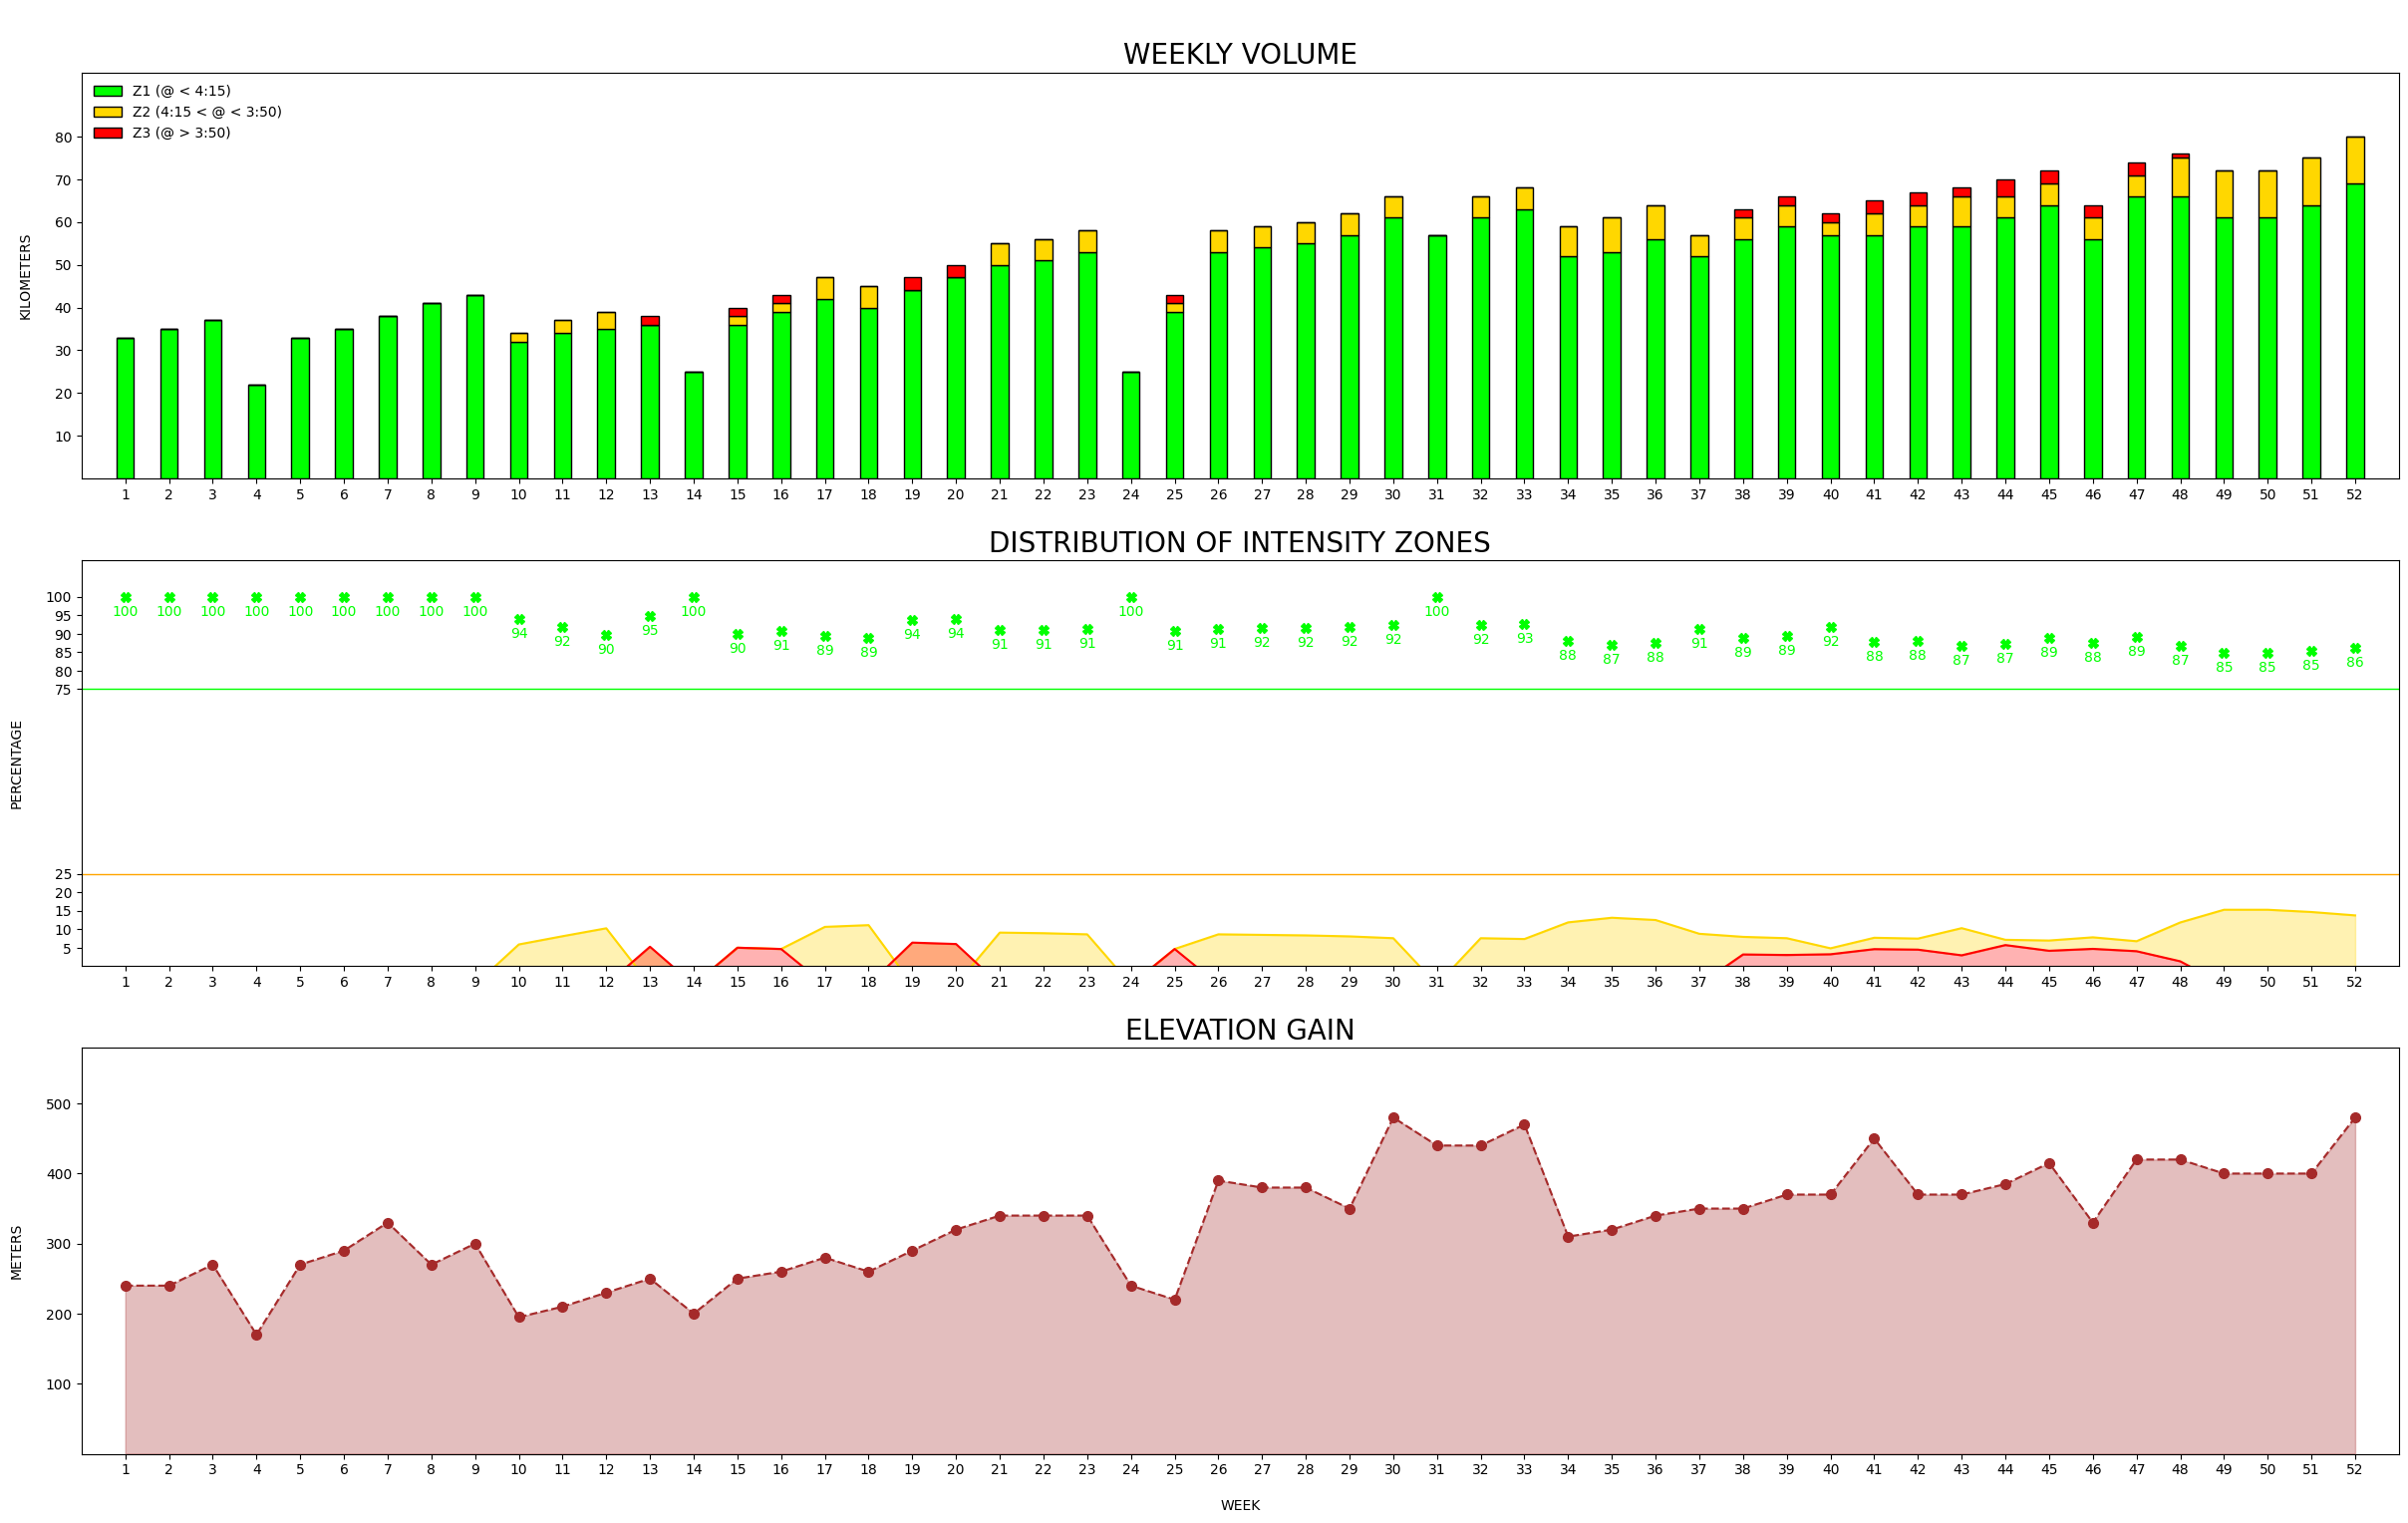

In [9]:
fig, (ax_volume, ax_distr, ax_eg) = plt.subplots(3, 1, figsize=(30, 18))

#set parameters of the graph
for ax in (ax_volume, ax_distr, ax_eg):
    ax.set_xticks(W) ; ax.set_xlim(min(W)-1, max(W)+1)
    
#set titles and labels
ax_volume.set_title("\nWEEKLY VOLUME", fontsize=20)
ax_volume.set_ylabel("KILOMETERS\n")
ax_distr.set_title("DISTRIBUTION OF INTENSITY ZONES", fontsize=20)
ax_distr.set_ylabel("PERCENTAGE\n")
ax_eg.set_title("\nELEVATION GAIN", fontsize=20)
ax_eg.set_ylabel("METERS\n")
ax_eg.set_xlabel("\nWEEK")

#volume graph
ax_volume.set_yticks(range(10, int(max(weekly_total))+10, 10))
ax_volume.set_ylim(0, int(max(weekly_total))+15)

ax_volume.bar(W, weekly_Z1, color="lime", edgecolor="black", width=0.4, linewidth=1, label="Z1 (@ < 4:15)")
ax_volume.bar(W, weekly_Z2, bottom = weekly_Z1, color="gold", edgecolor="black", width=0.4, linewidth=1, label="Z2 (4:15 < @ < 3:50)")
ax_volume.bar(W, weekly_Z3, bottom = weekly_Z1+weekly_Z2, color="red", edgecolor="black", width=0.4, linewidth=1, label="Z3 (@ > 3:50)")
ax_volume.legend(loc=2, frameon=False)

#distribution graph
ax_distr.set_yticks([5, 10, 15, 20, 25, 75, 80, 85, 90, 95, 100])
ax_distr.set_ylim(0, 110)

ax_distr.plot(W, D1, "X", ms=7, c="lime")
for i in range(N):
    ax_distr.text(i+1, D1[i]-4, str(round(D1[i])), color="lime", horizontalalignment="center", verticalalignment="center")
    
ax_distr.plot(W, D2, "-", ms=7, c="gold")
ax_distr.fill_between(W, D2, D3, color="gold", alpha=0.3)
ax_distr.plot(W, D3, "-", ms=7, c="red")
ax_distr.fill_between(W, D3, color="red", alpha=0.3)

ax_distr.axhline(y=25, color="orange", linestyle="-", lw=1)
ax_distr.axhline(y=75, color="lime", linestyle="-", lw=1)

#elevation gain
ax_eg.set_yticks(range(100, int(max(weekly_EG))+100, 100))
ax_eg.set_ylim(0, int(max(weekly_EG)+100))

ax_eg.plot(W, weekly_EG, "--o", ms=7, c="brown")
ax_eg.fill_between(W, weekly_EG, color="brown", alpha=0.3)

plt.show()

if save:
    fig.savefig("generated_graphs/running", dpi=1000)

### 2.3 – Workout graph

In [10]:
#weekly data
weekly_UPPER = np.sum(UPPER/60, axis=1) #converting to hours 
weekly_ABS = np.sum(ABS/60, axis=1) #converting to hours
weekly_LOWER = np.sum(LOWER/60, axis=1) #converting to hours
weekly_WORKOUT = np.sum(WORKOUT/60, axis=1) #converting to hours

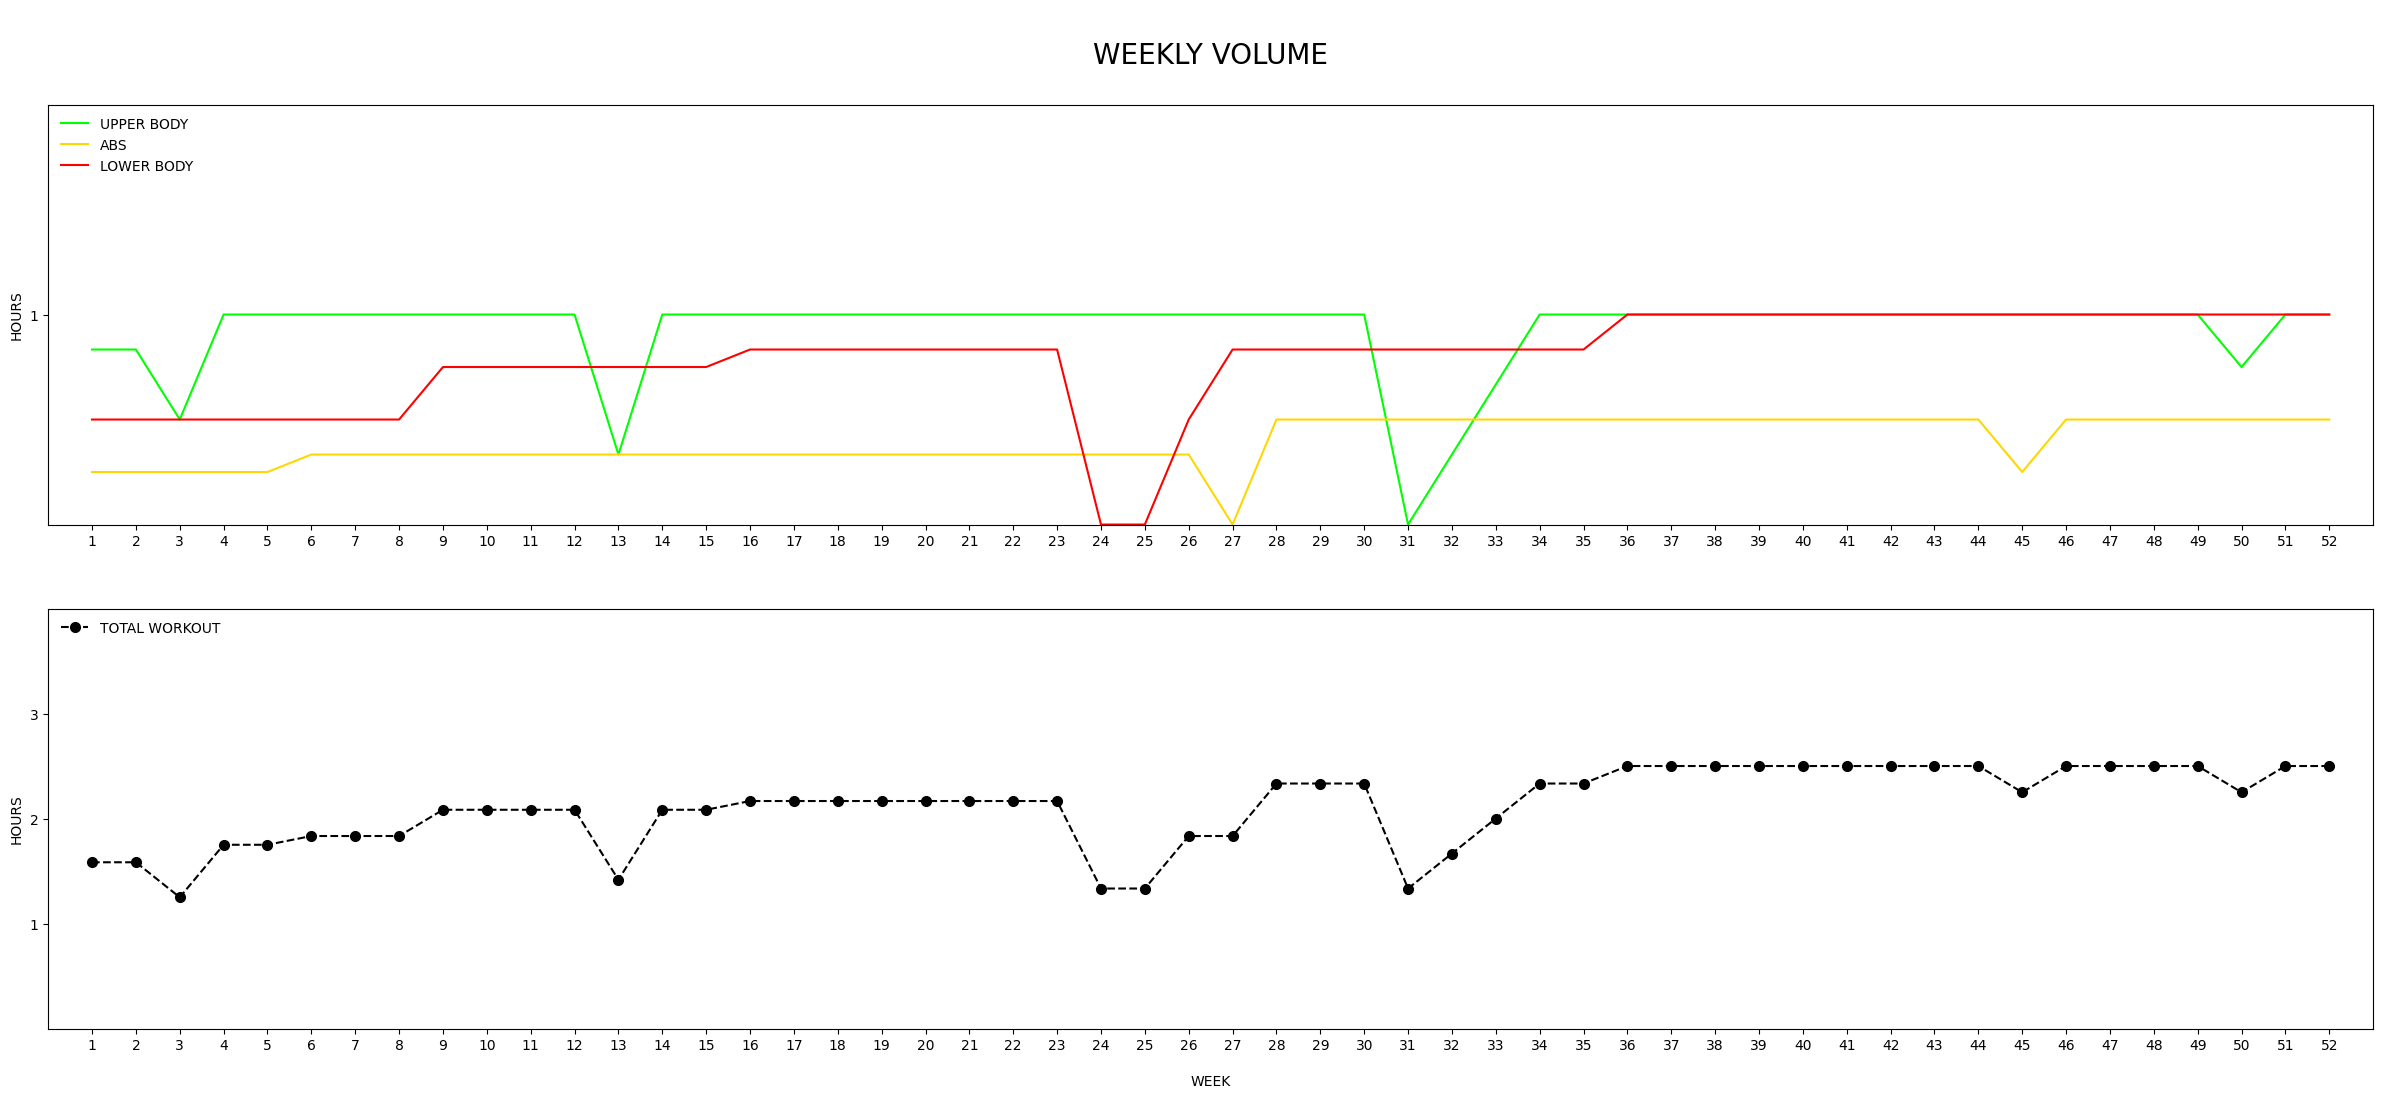

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 12))

#set parameters of the graph
for ax in (ax1, ax2):
    ax.set_xticks(W) ; ax.set_xlim(min(W)-1, max(W)+1)
    ax.set_ylabel("HOURS")

#set titles and labels
ax1.set_title("\nWEEKLY VOLUME\n", fontsize=20)
ax2.set_xlabel("\nWEEK")

#ax1
ax1.set_yticks(range(1, int(max([max(weekly_UPPER), max(weekly_ABS), max(weekly_LOWER)]))+1, 1))
ax1.set_ylim(0, int(max([max(weekly_UPPER), max(weekly_ABS), max(weekly_LOWER)])+1))

ax1.plot(W, weekly_UPPER, "-", c="lime", ms=10, label="UPPER BODY")
ax1.plot(W, weekly_ABS, "-", c="gold", ms=10, label="ABS")
ax1.plot(W, weekly_LOWER, "-", c="red", ms=10, label="LOWER BODY")
ax1.legend(loc=2, frameon=False)

#ax2
ax2.set_yticks(range(1, int(max(weekly_WORKOUT))+2, 1))
ax2.set_ylim(0, int(max(weekly_WORKOUT))+2)

ax2.plot(W, weekly_WORKOUT, "--o", c="black", ms=7, label="TOTAL WORKOUT")
ax2.legend(loc=2, frameon=False)

plt.show()

if save:
    fig.savefig("generated_graphs/workout", dpi=1000)